In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cols
import matplotlib.cm as cm

SingleDim = 9
UNOCCUPIED = 0

board = np.zeros(shape=(SingleDim,SingleDim), dtype=int)
board[0,2] = 1
board[2,1] = 1

vacant = board == UNOCCUPIED
v_it = zip(*np.nonzero(vacant))

v_it = np.array(list(zip(*np.nonzero(vacant))))
v2 = v_it.copy()
np.random.shuffle(v2)
v2 = v2[:14]
v2[:,0], v2[:,1]

(array([0, 7, 7, 2, 5, 2, 4, 3, 3, 1, 7, 5, 0, 2]),
 array([6, 5, 8, 4, 3, 6, 1, 8, 0, 4, 2, 0, 4, 0]))

In [61]:
board[v2[:,0], v2[:,1]] = [7,2,3,4,5,6,7,2,3,4,5,6,1,1]

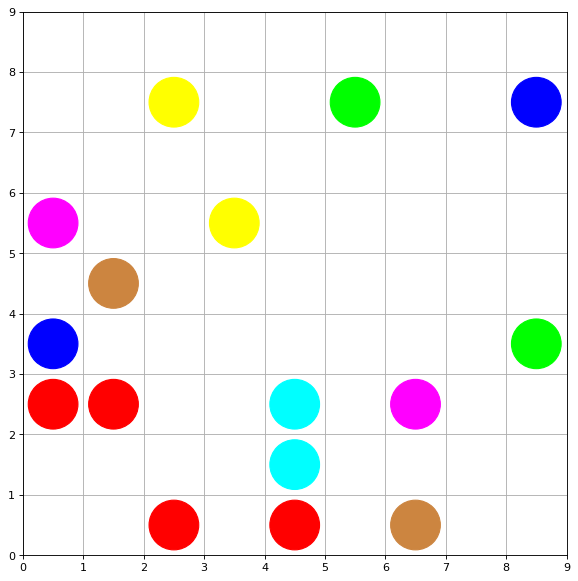

In [62]:
cmap = 'wrgybcm'
lines_cm = cols.ListedColormap([[1, 0, 0],
                               [0, 1, 0],
                               [0, 0, 1],
                               [0, 1, 1],
                               [1, 1, 0],
                               [1, 0, 1],
                               #[.6,.35,.4]
                               [.8,.52,.25]])

x,y = np.nonzero(board != UNOCCUPIED)
fig = plt.figure(figsize=(SingleDim,SingleDim), dpi=80)
ax = plt.subplot(111, aspect='equal', xlim=[0,SingleDim], ylim=[0,SingleDim], 
                 xticks=range(SingleDim+1), yticks=range(SingleDim+1))
#ax = plt.subplot(111, aspect='equal', xlim=[-0.5,SingleDim-0.5], ylim=[-0.5,SingleDim-0.5], 
#                 xticks=range(SingleDim), yticks=range(SingleDim))
ax.grid(True)
ax.scatter(y+0.5, x+0.5, s=2000, c=[board[x1,y1] for x1,y1 in zip(x,y)], 
           cmap=lines_cm)

In [6]:
plt.show()